In [11]:
import os
import pandas as pd
import numpy as np
import glob
import csv
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.style.use('bmh')

In [12]:
from scipy.stats import skew, kurtosis
from statsmodels.tsa import stattools
import numpy as np
import math

def jitter(v):
    """
    Calculate jitter in a vectorized form. Time axis is assumed to be 0.
    We assume, that `v` is 2D array.
    """
    return np.sum(np.abs(v.values[1:] - v.values[:-1]), axis=0)/v.shape[0]


def mean_crossing_rate(v):
        """
        Calculate MCR in a vectorized form. Time axis is assumed to be 0.
        We assume, that `v` is 2D array.
        """

        m = v.mean(axis=0)
        crossings = np.logical_or(np.logical_and((v.values > m)[1:], (v.values < m)[:-1]), # crossing downwards
                                  np.logical_and((v.values < m)[1:], (v.values > m)[:-1])) # crossing upwards
        return np.mean(crossings, axis=0)
    


In [13]:
''' v is a sample : assumed tobe a 2d array'''
# mean auto correlation
def acf_mean(v):
    return stattools.acf(v).mean()
# standard deviation auto correlation
def acf_std(v):
    return stattools.acf(v).std()
# mean auto covariance   
def acv_mean(v):
    return stattools.acovf(v).mean()
# standard deviation auto covariance
def acv_std(v):
    return stattools.acovf(v).std()
    
    
    

### read files into a dataframe

In [14]:
#reading the files:
DATA_DIR = "./nexar/"
!ls nexar

f1  f2	high_rated-2018-11-24  zero_rated-2018-11-24


In [15]:
samples_accel = glob.glob("nexar/*/*/*_Accel.csv")
samples_gyro=glob.glob("nexar/*/*/*_Gyro.csv")
print("there are {}  accel samples".format(len(samples_accel)))
print("there are {}  gyro samples".format(len(samples_gyro)))
samples_gyro[:10], samples_accel[:10]


there are 4133  accel samples
there are 4010  gyro samples


(['nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Gyro.csv',
  'nexar/zero_rated-2018-11-24/0899c7acdc74c1d2fc16b3ba7dff47c6/0899c7acdc74c1d2fc16b3ba7dff47c6_Gyro.csv',
  'nexar/zero_rated-2018-11-24/049b7df2a36aad19543151765819a213/049b7df2a36aad19543151765819a213_Gyro.csv',
  'nexar/zero_rated-2018-11-24/0515cba67277eed2d285e802421ba4da/0515cba67277eed2d285e802421ba4da_Gyro.csv',
  'nexar/zero_rated-2018-11-24/02680761599287696ed79852c0dd620a/02680761599287696ed79852c0dd620a_Gyro.csv',
  'nexar/zero_rated-2018-11-24/02568073d035831b1a48da560c66517f/02568073d035831b1a48da560c66517f_Gyro.csv',
  'nexar/zero_rated-2018-11-24/0c21adff6082397f894a4ada32f91799/0c21adff6082397f894a4ada32f91799_Gyro.csv',
  'nexar/zero_rated-2018-11-24/058189e924c41c47950b30187942036a/058189e924c41c47950b30187942036a_Gyro.csv',
  'nexar/zero_rated-2018-11-24/0a6d74cf9408ebac05765cc7fe5bb4d5/0a6d74cf9408ebac05765cc7fe5bb4d5_Gyro.csv',
  'nexar/zero_rated-2018-11-

In [16]:
def get_ids(fname):
    """Calculate `sample_id` and short filename."""
    start_dir, filename = os.path.split(fname)
    base_dir, sample_id = os.path.split(start_dir)
    _, sample_class = os.path.split(base_dir)
    sample_class= sample_class
    return (sample_id, sample_class, filename)


## Read file of gyro and of acceleration to see they are syncronic in time

In [17]:
#Let's read 1 file of gyro and 1 files of accelerometer:
accel_df= pd.read_csv("nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Gyro.csv")
gyro_df= pd.read_csv("nexar/zero_rated-2018-11-24/01664c5ac370136abc20d7ac52d0ec48/01664c5ac370136abc20d7ac52d0ec48_Accel.csv")
accel_df["timestamp"] = pd.to_datetime(accel_df['timestamp'], unit="s")
gyro_df["timestamp"] = pd.to_datetime(gyro_df['timestamp'], unit="s")
gyro_df=gyro_df.resample('1S', on="timestamp").mean()
accel_df=accel_df.resample('1S', on="timestamp").mean()

accel_df.head()

,signal_x,signal_y,signal_z
timestamp,,,
2018-10-19 12:40:58,-0.029127,0.008973,-0.061517
2018-10-19 12:40:59,-0.024144,0.002469,-0.016690
2018-10-19 12:41:00,-0.031487,0.008731,0.010558
2018-10-19 12:41:01,-0.047450,-0.009837,0.001671
2018-10-19 12:41:02,-0.028131,0.012825,0.049756


In [18]:
print(accel_df.shape, gyro_df.shape)
gyro_df.head()


(40, 3) (40, 3)


,signal_x,signal_y,signal_z
timestamp,,,
2018-10-19 12:40:58,-0.085731,-0.183673,-1.001654
2018-10-19 12:40:59,-0.049615,-0.184269,-1.001500
2018-10-19 12:41:00,-0.030558,-0.174962,-0.998231
2018-10-19 12:41:01,-0.048269,-0.136308,-0.993731
2018-10-19 12:41:02,-0.088769,-0.197827,-0.996404


In [19]:
files_accel=pd.DataFrame([get_ids(sample) for sample in samples_accel],
                     columns=["sample_id", "class", "accel_file"])
files_gyro=pd.DataFrame([get_ids(sample) for sample in samples_gyro],
                     columns=["sample_id", "class", "gyro_file"])

In [20]:
print("Accel: number of dangerous rides {}".format(files_accel[files_accel['class']=="high_rated-2018-11-24"].shape[0]))
print("Accel: number of not dangerous rides {}".format(files_accel[files_accel['class']=="zero_rated-2018-11-24"].shape[0]))
print("Accel:number of files: {}".format(files_accel.shape[0]))
print("Gyro: number of dangerous rides {}".format(files_gyro[files_gyro['class']=="high_rated-2018-11-24"].shape[0]))
print("Gyro: number of not dangerous rides {}".format(files_gyro[files_gyro['class']=="zero_rated-2018-11-24"].shape[0]))
print("Gyro:number of files: {}".format(files_gyro.shape[0]))

Accel: number of dangerous rides 2222
Accel: number of not dangerous rides 1911
Accel:number of files: 4133
Gyro: number of dangerous rides 2214
Gyro: number of not dangerous rides 1796
Gyro:number of files: 4010


In [21]:
files_gyro.head() ,files_accel.head()


(                          sample_id                  class  \
 0  01664c5ac370136abc20d7ac52d0ec48  zero_rated-2018-11-24   
 1  0899c7acdc74c1d2fc16b3ba7dff47c6  zero_rated-2018-11-24   
 2  049b7df2a36aad19543151765819a213  zero_rated-2018-11-24   
 3  0515cba67277eed2d285e802421ba4da  zero_rated-2018-11-24   
 4  02680761599287696ed79852c0dd620a  zero_rated-2018-11-24   
 
                                    gyro_file  
 0  01664c5ac370136abc20d7ac52d0ec48_Gyro.csv  
 1  0899c7acdc74c1d2fc16b3ba7dff47c6_Gyro.csv  
 2  049b7df2a36aad19543151765819a213_Gyro.csv  
 3  0515cba67277eed2d285e802421ba4da_Gyro.csv  
 4  02680761599287696ed79852c0dd620a_Gyro.csv  ,
                           sample_id                  class  \
 0  01664c5ac370136abc20d7ac52d0ec48  zero_rated-2018-11-24   
 1  0899c7acdc74c1d2fc16b3ba7dff47c6  zero_rated-2018-11-24   
 2  049b7df2a36aad19543151765819a213  zero_rated-2018-11-24   
 3  0515cba67277eed2d285e802421ba4da  zero_rated-2018-11-24   
 4  026807615992

In [22]:
files_accel['class_number']= files_accel['class'].map({"zero_rated-2018-11-24":0,"high_rated-2018-11-24":1})
files_gyro['class_number']= files_gyro['class'].map({"zero_rated-2018-11-24":0,"high_rated-2018-11-24":1})


### Merge the two files

In [23]:
files=files_accel.merge(files_gyro,left_on='sample_id', right_on='sample_id', how="inner" ,suffixes=('_accel', '_gyro'))
print(files.shape)
files.tail()

(4008, 7)


,sample_id,class_accel,accel_file,class_number_accel,class_gyro,gyro_file,class_number_gyro
4003,19f92c0d70ffab7a4a1ce0eb170112a3,high_rated-2018-11-24,19f92c0d70ffab7a4a1ce0eb170112a3_Accel.csv,1,high_rated-2018-11-24,19f92c0d70ffab7a4a1ce0eb170112a3_Gyro.csv,1
4004,3be8fa37d1866c50e89716839e25e90a,high_rated-2018-11-24,3be8fa37d1866c50e89716839e25e90a_Accel.csv,1,high_rated-2018-11-24,3be8fa37d1866c50e89716839e25e90a_Gyro.csv,1
4005,31ae47b0a0c883ede3a263daa9037ea7,high_rated-2018-11-24,31ae47b0a0c883ede3a263daa9037ea7_Accel.csv,1,high_rated-2018-11-24,31ae47b0a0c883ede3a263daa9037ea7_Gyro.csv,1
4006,a2a7ab14e2a265cd1f786e1e13a80b23,high_rated-2018-11-24,a2a7ab14e2a265cd1f786e1e13a80b23_Accel.csv,1,high_rated-2018-11-24,a2a7ab14e2a265cd1f786e1e13a80b23_Gyro.csv,1
4007,83d25b2b1066b26bf188f6c536a1caa2,high_rated-2018-11-24,83d25b2b1066b26bf188f6c536a1caa2_Accel.csv,1,high_rated-2018-11-24,83d25b2b1066b26bf188f6c536a1caa2_Gyro.csv,1


#### split the data to train /test 

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(files[['sample_id',"class_accel","accel_file","gyro_file"]], files['class_number_accel'], test_size=0.2, random_state=42)

In [25]:
print(X_train.shape)
X_train.rename(columns={"class_accel": "class"}, inplace=True)
X_test.rename(columns={"class_accel": "class"}, inplace=True)
X_train.head() , y_train.head()

(3206, 4)


(                             sample_id                  class  \
 2473  7168b0879c82cab9f7effde6cef8de45  high_rated-2018-11-24   
 1338  0010d7fe0b451efaf012a0b1eacaafdd  zero_rated-2018-11-24   
 1613  06cc71e6123e4d235d2c832172c37004  zero_rated-2018-11-24   
 1610  07e62df17ba5ba3ad0230f7837955b95  zero_rated-2018-11-24   
 2600  8cf81206adb8517f9afdfdecad888b6a  high_rated-2018-11-24   
 
                                       accel_file  \
 2473  7168b0879c82cab9f7effde6cef8de45_Accel.csv   
 1338  0010d7fe0b451efaf012a0b1eacaafdd_Accel.csv   
 1613  06cc71e6123e4d235d2c832172c37004_Accel.csv   
 1610  07e62df17ba5ba3ad0230f7837955b95_Accel.csv   
 2600  8cf81206adb8517f9afdfdecad888b6a_Accel.csv   
 
                                       gyro_file  
 2473  7168b0879c82cab9f7effde6cef8de45_Gyro.csv  
 1338  0010d7fe0b451efaf012a0b1eacaafdd_Gyro.csv  
 1613  06cc71e6123e4d235d2c832172c37004_Gyro.csv  
 1610  07e62df17ba5ba3ad0230f7837955b95_Gyro.csv  
 2600  8cf81206adb8517f9afd

In [26]:
def generate_features(base_dir, sample_class, sample_id, filename):
    # Reading
    fullname = os.path.join(base_dir, sample_class, sample_id, filename)
#     print("full name: {}".format(fullname))
    sample = pd.read_csv(fullname)
#     print(sample.shape)
#     print(sample.head()) 
    # Handling timestamps and spacing
    sample["timestamp"] = pd.to_datetime(sample['timestamp'], unit="s")
    
    
    
    sample = sample.resample('1S', on="timestamp").mean()
#     print(sample.shape)
#     print(sample.head())
    
    # Acceleration
    sample["magnitude"] = np.sqrt(np.square(sample).sum(axis=1))
    
    # Statistical aggregates

    # Note the trickery to get right format from pandas
    # without manual renaming
    aggs = (sample
            .apply(["mean", "std", "min", "max","median","skew","kurtosis",acf_mean,acf_std,acv_mean,acv_std,jitter,mean_crossing_rate])
            .unstack()
            .reset_index())
    aggs["feature"] = aggs["level_0"].str.cat(aggs["level_1"], sep="_{}_".format(filename.split("_")[1].split(".")[0]))

    return aggs.set_index("feature")[0]
    

In [27]:
 #generate features for 1 sample
ac=generate_features(DATA_DIR, *X_train[["class", "sample_id", "accel_file"]].loc[0,:].tolist())
gy=generate_features(DATA_DIR, *X_train[["class", "sample_id", "gyro_file"]].loc[0,:].tolist())
print(ac.shape, gy.shape)


(52,) (52,)


In [28]:
accel_stat_features = X_train.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


In [29]:
gyro_stat_features = X_train.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "gyro_file"]].tolist()),
                            axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


In [30]:
y_train.head()

2473    1
1338    0
1613    0
1610    0
2600    1
Name: class_number_accel, dtype: int64

In [31]:
accel_stat_features.head()
accel_stat_features.shape

(3206, 52)

In [32]:
gyro_stat_features.head()
gyro_stat_features.shape

(3206, 52)

In [33]:
stat_features=pd.concat([accel_stat_features,gyro_stat_features], axis=1)
print(stat_features.shape)
stat_features.head()

(3206, 104)


feature,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,magnitude_Gyro_max,magnitude_Gyro_median,magnitude_Gyro_skew,magnitude_Gyro_kurtosis,magnitude_Gyro_acf_mean,magnitude_Gyro_acf_std,magnitude_Gyro_acv_mean,magnitude_Gyro_acv_std,magnitude_Gyro_jitter,magnitude_Gyro_mean_crossing_rate
2473,0.137321,0.091261,-0.13616,0.379140,0.13284,-0.148314,2.794951,0.012500,0.233042,0.000102,...,0.148617,0.041629,1.509877,1.142519,0.012500,0.234018,0.000017,0.000320,0.016217,0.205128
1338,0.034743,0.035457,-0.08652,0.124531,0.04044,-1.471731,4.853803,0.012500,0.215037,0.000015,...,0.163628,0.072409,2.773242,8.636971,0.012500,0.186683,0.000005,0.000070,0.014894,0.256410
1613,-0.998569,0.012663,-1.02238,-0.970240,-0.99778,0.169027,-0.216966,0.012500,0.214022,0.000002,...,0.275688,0.037226,2.514087,5.630210,0.012500,0.233945,0.000049,0.000921,0.027200,0.230769
1610,-0.024799,0.023327,-0.09962,0.016420,-0.02244,-0.672583,1.403692,0.012500,0.207627,0.000007,...,0.124450,0.025860,3.821294,17.402189,0.012500,0.188700,0.000004,0.000063,0.011541,0.256410
2600,0.067214,0.068354,-0.07922,0.320340,0.06196,1.442174,4.731296,0.012195,0.185021,0.000056,...,0.386291,0.033451,2.791054,7.081436,0.012195,0.213661,0.000100,0.001751,0.039122,0.150000


### training the model in 40 (or 41) second timeframe features
#### Every Csv file is generating 1 set of features

In [34]:
X = stat_features
y = y_train

In [35]:
#Drop Nans
X.dropna(axis=0, how="any",inplace=True)
y=y[X.index]

In [36]:
print(f'X.shape:{X.shape}')
print(f'y.shape:{y.shape}')

X.shape:(3188, 104)
y.shape:(3188,)


In [37]:
X.head(), y.head()

(feature  signal_x_Accel_mean  signal_x_Accel_std  signal_x_Accel_min  \
 2473                0.137321            0.091261            -0.13616   
 1338                0.034743            0.035457            -0.08652   
 1613               -0.998569            0.012663            -1.02238   
 1610               -0.024799            0.023327            -0.09962   
 2600                0.067214            0.068354            -0.07922   
 
 feature  signal_x_Accel_max  signal_x_Accel_median  signal_x_Accel_skew  \
 2473               0.379140                0.13284            -0.148314   
 1338               0.124531                0.04044            -1.471731   
 1613              -0.970240               -0.99778             0.169027   
 1610               0.016420               -0.02244            -0.672583   
 2600               0.320340                0.06196             1.442174   
 
 feature  signal_x_Accel_kurtosis  signal_x_Accel_acf_mean  \
 2473                    2.794951       

### accuracy scores based on files split

The idea of this measure would be to provide a ride sample each time, split into 1 second segments, predict on the whole sample, define a threshold (0.5?), and compare it to ground truth.

In [38]:

X_test.head() , y_test.head()

(                             sample_id                  class  \
 2580  a1554305a5032cbac096740919747819  high_rated-2018-11-24   
 3659  734f3810f0ff811a182b7d017a67d107  high_rated-2018-11-24   
 897   07ce010d4b7555dd11a1664b4ecfae00  zero_rated-2018-11-24   
 2091  86b2e555e62d23184827f8e287286cb3  high_rated-2018-11-24   
 1044  029f64f8f8e1b694adb05739c20059b5  zero_rated-2018-11-24   
 
                                       accel_file  \
 2580  a1554305a5032cbac096740919747819_Accel.csv   
 3659  734f3810f0ff811a182b7d017a67d107_Accel.csv   
 897   07ce010d4b7555dd11a1664b4ecfae00_Accel.csv   
 2091  86b2e555e62d23184827f8e287286cb3_Accel.csv   
 1044  029f64f8f8e1b694adb05739c20059b5_Accel.csv   
 
                                       gyro_file  
 2580  a1554305a5032cbac096740919747819_Gyro.csv  
 3659  734f3810f0ff811a182b7d017a67d107_Gyro.csv  
 897   07ce010d4b7555dd11a1664b4ecfae00_Gyro.csv  
 2091  86b2e555e62d23184827f8e287286cb3_Gyro.csv  
 1044  029f64f8f8e1b694adb0

In [39]:
single_sample = X_test.iloc[0,:]
single_sample

sample_id               a1554305a5032cbac096740919747819
class                              high_rated-2018-11-24
accel_file    a1554305a5032cbac096740919747819_Accel.csv
gyro_file      a1554305a5032cbac096740919747819_Gyro.csv
Name: 2580, dtype: object

#### generate features for test data

In [40]:
features_test_accel = X_test.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)
features_test_gyro =X_test.apply(lambda f: generate_features(DATA_DIR, *f[["class", "sample_id", "gyro_file"]].tolist()),
                            axis=1)

features_test_accel.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


feature,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,magnitude_Accel_max,magnitude_Accel_median,magnitude_Accel_skew,magnitude_Accel_kurtosis,magnitude_Accel_acf_mean,magnitude_Accel_acf_std,magnitude_Accel_acv_mean,magnitude_Accel_acv_std,magnitude_Accel_jitter,magnitude_Accel_mean_crossing_rate
2580,0.999499,0.009976,0.973080,1.027640,0.999590,0.495104,1.908193,0.0125,0.219802,0.000001,...,1.092053,1.005998,1.858903,3.201737,0.0125,0.202302,0.000007,0.000113,0.011985,0.179487
3659,-0.038279,0.031786,-0.071235,0.093725,-0.048720,2.876770,8.922087,0.0125,0.180077,0.000012,...,1.146176,0.987400,5.196223,30.372146,0.0125,0.170448,0.000008,0.000115,0.014645,0.384615
897,0.027602,0.118498,-0.285404,0.196923,0.053817,-0.390112,-0.716699,0.0125,0.304842,0.000171,...,1.028959,1.008849,-5.603349,33.906636,0.0125,0.161071,0.000014,0.000186,0.016402,0.179487
2091,0.035742,0.081586,-0.051560,0.283900,0.004478,1.901147,3.247621,0.0125,0.247264,0.000081,...,1.082282,1.008704,1.592734,2.884553,0.0125,0.183339,0.000005,0.000080,0.016199,0.358974
1044,0.011218,0.092751,-0.176320,0.248720,-0.016630,0.836768,0.703867,0.0125,0.321711,0.000105,...,1.033243,0.997738,1.245921,3.287400,0.0125,0.193236,0.000001,0.000017,0.006636,0.256410


In [41]:
features_test_gyro.head()

feature,signal_x_Gyro_mean,signal_x_Gyro_std,signal_x_Gyro_min,signal_x_Gyro_max,signal_x_Gyro_median,signal_x_Gyro_skew,signal_x_Gyro_kurtosis,signal_x_Gyro_acf_mean,signal_x_Gyro_acf_std,signal_x_Gyro_acv_mean,...,magnitude_Gyro_max,magnitude_Gyro_median,magnitude_Gyro_skew,magnitude_Gyro_kurtosis,magnitude_Gyro_acf_mean,magnitude_Gyro_acf_std,magnitude_Gyro_acv_mean,magnitude_Gyro_acv_std,magnitude_Gyro_jitter,magnitude_Gyro_mean_crossing_rate
2580,-0.002178,0.145775,-0.366644,0.439060,0.001804,-0.031780,3.425358,0.0125,0.261165,0.000259,...,0.440950,0.022112,1.819584,1.866170,0.0125,0.253179,0.000180,0.003651,0.041759,0.076923
3659,0.019812,0.009538,-0.017184,0.041954,0.019658,-0.927129,5.631307,0.0125,0.174396,0.000001,...,0.130244,0.058335,1.669929,3.781587,0.0125,0.176290,0.000005,0.000072,0.014000,0.307692
897,0.106660,0.509745,-0.344404,3.184575,0.028258,5.910946,36.539141,0.0125,0.162140,0.003167,...,3.510656,0.075263,4.812265,24.585934,0.0125,0.173839,0.004353,0.060540,0.232159,0.102564
2091,0.007256,0.010987,-0.013958,0.044396,0.006082,0.972513,2.605876,0.0125,0.214001,0.000001,...,0.405312,0.019656,2.765529,6.756573,0.0125,0.235018,0.000117,0.002196,0.026990,0.076923
1044,0.007719,0.105737,-0.228086,0.451506,-0.002562,2.152462,9.918774,0.0125,0.186653,0.000136,...,0.677585,0.039077,1.737214,1.802630,0.0125,0.241076,0.000462,0.008919,0.088001,0.153846


In [42]:
features_test=pd.concat([features_test_accel,features_test_gyro], axis=1)
print(features_test.shape)


(802, 104)


feature,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,magnitude_Gyro_max,magnitude_Gyro_median,magnitude_Gyro_skew,magnitude_Gyro_kurtosis,magnitude_Gyro_acf_mean,magnitude_Gyro_acf_std,magnitude_Gyro_acv_mean,magnitude_Gyro_acv_std,magnitude_Gyro_jitter,magnitude_Gyro_mean_crossing_rate
2580,0.999499,0.009976,0.973080,1.027640,0.999590,0.495104,1.908193,0.0125,0.219802,0.000001,...,0.440950,0.022112,1.819584,1.866170,0.0125,0.253179,0.000180,0.003651,0.041759,0.076923
3659,-0.038279,0.031786,-0.071235,0.093725,-0.048720,2.876770,8.922087,0.0125,0.180077,0.000012,...,0.130244,0.058335,1.669929,3.781587,0.0125,0.176290,0.000005,0.000072,0.014000,0.307692
897,0.027602,0.118498,-0.285404,0.196923,0.053817,-0.390112,-0.716699,0.0125,0.304842,0.000171,...,3.510656,0.075263,4.812265,24.585934,0.0125,0.173839,0.004353,0.060540,0.232159,0.102564
2091,0.035742,0.081586,-0.051560,0.283900,0.004478,1.901147,3.247621,0.0125,0.247264,0.000081,...,0.405312,0.019656,2.765529,6.756573,0.0125,0.235018,0.000117,0.002196,0.026990,0.076923
1044,0.011218,0.092751,-0.176320,0.248720,-0.016630,0.836768,0.703867,0.0125,0.321711,0.000105,...,0.677585,0.039077,1.737214,1.802630,0.0125,0.241076,0.000462,0.008919,0.088001,0.153846


In [47]:
#Drop Nans
features_test.dropna(axis=0, how="any",inplace=True)
y_test=y_test[features_test.index]

In [48]:
features_test.head()

feature,signal_x_Accel_mean,signal_x_Accel_std,signal_x_Accel_min,signal_x_Accel_max,signal_x_Accel_median,signal_x_Accel_skew,signal_x_Accel_kurtosis,signal_x_Accel_acf_mean,signal_x_Accel_acf_std,signal_x_Accel_acv_mean,...,magnitude_Gyro_max,magnitude_Gyro_median,magnitude_Gyro_skew,magnitude_Gyro_kurtosis,magnitude_Gyro_acf_mean,magnitude_Gyro_acf_std,magnitude_Gyro_acv_mean,magnitude_Gyro_acv_std,magnitude_Gyro_jitter,magnitude_Gyro_mean_crossing_rate
2580,0.999499,0.009976,0.973080,1.027640,0.999590,0.495104,1.908193,0.0125,0.219802,0.000001,...,0.440950,0.022112,1.819584,1.866170,0.0125,0.253179,0.000180,0.003651,0.041759,0.076923
3659,-0.038279,0.031786,-0.071235,0.093725,-0.048720,2.876770,8.922087,0.0125,0.180077,0.000012,...,0.130244,0.058335,1.669929,3.781587,0.0125,0.176290,0.000005,0.000072,0.014000,0.307692
897,0.027602,0.118498,-0.285404,0.196923,0.053817,-0.390112,-0.716699,0.0125,0.304842,0.000171,...,3.510656,0.075263,4.812265,24.585934,0.0125,0.173839,0.004353,0.060540,0.232159,0.102564
2091,0.035742,0.081586,-0.051560,0.283900,0.004478,1.901147,3.247621,0.0125,0.247264,0.000081,...,0.405312,0.019656,2.765529,6.756573,0.0125,0.235018,0.000117,0.002196,0.026990,0.076923
1044,0.011218,0.092751,-0.176320,0.248720,-0.016630,0.836768,0.703867,0.0125,0.321711,0.000105,...,0.677585,0.039077,1.737214,1.802630,0.0125,0.241076,0.000462,0.008919,0.088001,0.153846


## Modeling
### training with gradient boosting

In [6]:
# !sudo conda install -c conda-forge catboost
# !sudo pip3  install catboost 
# # !sudo pip3 install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

sudo: conda: command not found


In [49]:
from sklearn.ensemble import GradientBoostingClassifier
c=GradientBoostingClassifier(n_estimators=200, learning_rate=1.0).fit(X, y)

## Predict and calculate accuracy

In [50]:
pred= c.predict(features_test)
score=c.score(features_test,y_test)
score

0.793233082706767

In [51]:
#calculate the accuracy- looks like too good to be True
acc=np.mean(pred==y_test)
acc

0.793233082706767

In [52]:
#predict proba
y_proba=c.predict_proba(features_test)
y_proba

array([[5.92793768e-03, 9.94072062e-01],
       [6.04614855e-05, 9.99939539e-01],
       [9.99976632e-01, 2.33683268e-05],
       ...,
       [5.90432935e-01, 4.09567065e-01],
       [4.58236830e-07, 9.99999542e-01],
       [9.88755542e-01, 1.12444584e-02]])

In [56]:
# the the probabilities for the 1 class
y_proba_1=pd.DataFrame(y_proba).iloc[:,1].tolist()
y_proba_1

[0.9940720623201357,
 0.9999395385145101,
 2.3368326787342355e-05,
 0.010406637592884174,
 0.10287288550157787,
 0.17670388754529873,
 0.042071652939730926,
 0.964894467519927,
 0.9999883905699039,
 0.9976093881830718,
 0.8337556097084599,
 0.9999997638059996,
 0.9997254240953017,
 0.9849577366023543,
 0.04458305565325762,
 0.9980598823764152,
 0.03503952232744995,
 0.9994274587290821,
 0.29466953298767357,
 0.0015320451029514515,
 0.9999916206211766,
 7.246520555014825e-07,
 0.01303772816483823,
 0.17546271345832817,
 0.994486593864631,
 0.0001348512566957022,
 0.9976086504046701,
 0.9906704955653614,
 0.997507917213811,
 0.7932266857603234,
 3.003415224423529e-06,
 0.6377208325693715,
 0.0012947391313750992,
 0.9945632185146517,
 0.2041276953170388,
 0.8631002005602844,
 0.9056646602394669,
 0.4440092057688067,
 0.9267439868766987,
 0.9999995812904475,
 1.2428217816846703e-07,
 0.00033009085454462723,
 0.9999881692290836,
 0.9465797037811015,
 0.8784548569154393,
 0.9978794907373801,


100%|██████████| 190/190 [02:40<00:00,  1.20it/s]

 70%|███████   | 155/221 [02:08<00:54,  1.22it/s]/Users/anikitin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]

100%|██████████| 221/221 [03:04<00:00,  1.21it/s]


In [53]:
#performance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def classification_metrics(y_true, y_pred, y_proba, target_names=['False', 'True']):
    
    #print(f'Zero class count:{len(y_true[y_true == 0])}')
    #print(f'One class count:{len(y_true[y_true == 1])}\n')
    
    columns = pd.MultiIndex.from_product([['Predicted Label'], target_names])
    index = pd.MultiIndex.from_product([['True Label'], target_names])
    display(pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns, index=index))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print(" ")
    print("=========================================================")
    print("Prediction simulation:")
    total_values = tn + fp + fn + tp
    print("True Highrated:{}".format((tp + fn) / total_values))
    print("Predicted Highrated:{}".format((tp + fp) / total_values))
    
    print("=========================================================")
    print(" ")
    
    print("Accuracy score: ",accuracy_score(y_true, y_pred))
    print("Balanced accuracy: {}".format(0.5*((tn/(tn+fn)) + (tp/(tp+fp)))))
    print(" ")
    
    print(classification_report(y_true, y_pred))
    print('ROC AUC: {}'.format(roc_auc_score(y_true, y_proba)))
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    plt.figure(figsize=(9,8))
    plt.plot(fpr, tpr)
    # Precision recall curve
    p, r, thresholds = precision_recall_curve(y_true, y_proba)
    plt.plot(r, p)
    plt.xlabel('FPR / Recall')
    plt.ylabel('TPR / Precision')
    plt.title('ROC / PR')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    # ROC AUC.

Predicted Label     
                           0    1
True Label 0             271  100
           1              65  362

 
Prediction simulation:
True Highrated:0.5350877192982456
Predicted Highrated:0.5789473684210527
 
Accuracy score:  0.793233082706767
Balanced accuracy: 0.7950487012987013
 
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       371
           1       0.78      0.85      0.81       427

   micro avg       0.79      0.79      0.79       798
   macro avg       0.80      0.79      0.79       798
weighted avg       0.79      0.79      0.79       798

ROC AUC: 0.8692312062468043


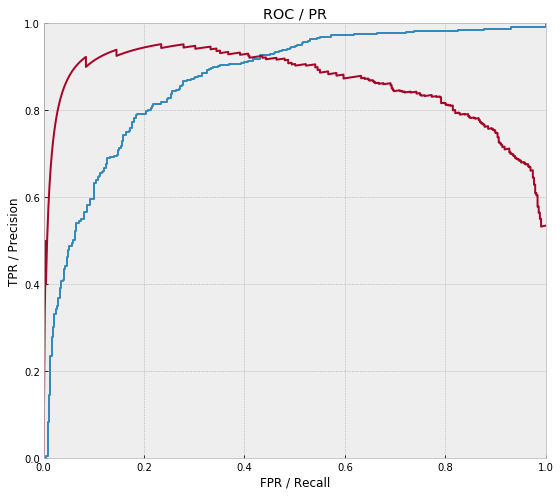

In [57]:
classification_metrics(y_test, pred, y_proba_1, target_names=[0, 1])   

In [94]:
features_test.columns[52:]

Index(['signal_x_Gyro_mean', 'signal_x_Gyro_std', 'signal_x_Gyro_min',
       'signal_x_Gyro_max', 'signal_x_Gyro_median', 'signal_x_Gyro_skew',
       'signal_x_Gyro_kurtosis', 'signal_x_Gyro_acf_mean',
       'signal_x_Gyro_acf_std', 'signal_x_Gyro_acv_mean',
       'signal_x_Gyro_acv_std', 'signal_x_Gyro_jitter',
       'signal_x_Gyro_mean_crossing_rate', 'signal_y_Gyro_mean',
       'signal_y_Gyro_std', 'signal_y_Gyro_min', 'signal_y_Gyro_max',
       'signal_y_Gyro_median', 'signal_y_Gyro_skew', 'signal_y_Gyro_kurtosis',
       'signal_y_Gyro_acf_mean', 'signal_y_Gyro_acf_std',
       'signal_y_Gyro_acv_mean', 'signal_y_Gyro_acv_std',
       'signal_y_Gyro_jitter', 'signal_y_Gyro_mean_crossing_rate',
       'signal_z_Gyro_mean', 'signal_z_Gyro_std', 'signal_z_Gyro_min',
       'signal_z_Gyro_max', 'signal_z_Gyro_median', 'signal_z_Gyro_skew',
       'signal_z_Gyro_kurtosis', 'signal_z_Gyro_acf_mean',
       'signal_z_Gyro_acf_std', 'signal_z_Gyro_acv_mean',
       'signal_z_Gyro_a

In [59]:
'''
      'signal_x_Gyro_mean', 'signal_x_Gyro_std', 'signal_x_Gyro_min',
       'signal_x_Gyro_max', 'signal_x_Gyro_median', 'signal_x_Gyro_skew',
       'signal_x_Gyro_kurtosis', 'signal_x_Gyro_acf_mean',
       'signal_x_Gyro_acf_std', 'signal_x_Gyro_acv_mean',
       'signal_x_Gyro_acv_std', 'signal_x_Gyro_jitter',
       'signal_x_Gyro_mean_crossing_rate', 'signal_y_Gyro_mean',
       'signal_y_Gyro_std', 'signal_y_Gyro_min', 'signal_y_Gyro_max',
       'signal_y_Gyro_median', 'signal_y_Gyro_skew', 'signal_y_Gyro_kurtosis',
       'signal_y_Gyro_acf_mean', 'signal_y_Gyro_acf_std',
       'signal_y_Gyro_acv_mean', 'signal_y_Gyro_acv_std',
       'signal_y_Gyro_jitter', 'signal_y_Gyro_mean_crossing_rate',
       'signal_z_Gyro_mean', 'signal_z_Gyro_std', 'signal_z_Gyro_min',
       'signal_z_Gyro_max', 'signal_z_Gyro_median', 'signal_z_Gyro_skew',
       'signal_z_Gyro_kurtosis', 'signal_z_Gyro_acf_mean',
       'signal_z_Gyro_acf_std', 'signal_z_Gyro_acv_mean',
       'signal_z_Gyro_acv_std', 'signal_z_Gyro_jitter',
       'signal_z_Gyro_mean_crossing_rate', 'magnitude_Gyro_mean',
       'magnitude_Gyro_std', 'magnitude_Gyro_min', 'magnitude_Gyro_max',
       'magnitude_Gyro_median', 'magnitude_Gyro_skew',
       'magnitude_Gyro_kurtosis', 'magnitude_Gyro_acf_mean',
       'magnitude_Gyro_acf_std', 'magnitude_Gyro_acv_mean',
       'magnitude_Gyro_acv_std', 'magnitude_Gyro_jitter',
       'magnitude_Gyro_mean_crossing_rate'
'''

FEATURES_COLS = [
   'signal_x_Accel_mean', 'signal_x_Accel_std', 'signal_x_Accel_min',
       'signal_x_Accel_max', 'signal_x_Accel_median', 'signal_x_Accel_skew',
       'signal_x_Accel_kurtosis', 'signal_x_Accel_acf_mean',
       'signal_x_Accel_acf_std', 'signal_x_Accel_acv_mean',
       'signal_x_Accel_acv_std', 'signal_x_Accel_jitter',
       'signal_x_Accel_mean_crossing_rate', 'signal_y_Accel_mean',
       'signal_y_Accel_std', 'signal_y_Accel_min', 'signal_y_Accel_max',
       'signal_y_Accel_median', 'signal_y_Accel_skew',
       'signal_y_Accel_kurtosis', 'signal_y_Accel_acf_mean',
       'signal_y_Accel_acf_std', 'signal_y_Accel_acv_mean',
       'signal_y_Accel_acv_std', 'signal_y_Accel_jitter',
       'signal_y_Accel_mean_crossing_rate', 'signal_z_Accel_mean',
       'signal_z_Accel_std', 'signal_z_Accel_min', 'signal_z_Accel_max',
       'signal_z_Accel_median', 'signal_z_Accel_skew',
       'signal_z_Accel_kurtosis', 'signal_z_Accel_acf_mean',
       'signal_z_Accel_acf_std', 'signal_z_Accel_acv_mean',
       'signal_z_Accel_acv_std', 'signal_z_Accel_jitter',
       'signal_z_Accel_mean_crossing_rate', 'magnitude_Accel_mean',
       'magnitude_Accel_std', 'magnitude_Accel_min', 'magnitude_Accel_max',
       'magnitude_Accel_median', 'magnitude_Accel_skew',
       'magnitude_Accel_kurtosis', 'magnitude_Accel_acf_mean',
       'magnitude_Accel_acf_std', 'magnitude_Accel_acv_mean',
       'magnitude_Accel_acv_std', 'magnitude_Accel_jitter',
       'magnitude_Accel_mean_crossing_rate',
        'signal_x_Gyro_mean', 'signal_x_Gyro_std', 'signal_x_Gyro_min',
       'signal_x_Gyro_max', 'signal_x_Gyro_median', 'signal_x_Gyro_skew',
       'signal_x_Gyro_kurtosis', 'signal_x_Gyro_acf_mean',
       'signal_x_Gyro_acf_std', 'signal_x_Gyro_acv_mean',
       'signal_x_Gyro_acv_std', 'signal_x_Gyro_jitter',
       'signal_x_Gyro_mean_crossing_rate', 'signal_y_Gyro_mean',
       'signal_y_Gyro_std', 'signal_y_Gyro_min', 'signal_y_Gyro_max',
       'signal_y_Gyro_median', 'signal_y_Gyro_skew', 'signal_y_Gyro_kurtosis',
       'signal_y_Gyro_acf_mean', 'signal_y_Gyro_acf_std',
       'signal_y_Gyro_acv_mean', 'signal_y_Gyro_acv_std',
       'signal_y_Gyro_jitter', 'signal_y_Gyro_mean_crossing_rate',
       'signal_z_Gyro_mean', 'signal_z_Gyro_std', 'signal_z_Gyro_min',
       'signal_z_Gyro_max', 'signal_z_Gyro_median', 'signal_z_Gyro_skew',
       'signal_z_Gyro_kurtosis', 'signal_z_Gyro_acf_mean',
       'signal_z_Gyro_acf_std', 'signal_z_Gyro_acv_mean',
       'signal_z_Gyro_acv_std', 'signal_z_Gyro_jitter',
       'signal_z_Gyro_mean_crossing_rate', 'magnitude_Gyro_mean',
       'magnitude_Gyro_std', 'magnitude_Gyro_min', 'magnitude_Gyro_max',
       'magnitude_Gyro_median', 'magnitude_Gyro_skew',
       'magnitude_Gyro_kurtosis', 'magnitude_Gyro_acf_mean',
       'magnitude_Gyro_acf_std', 'magnitude_Gyro_acv_mean',
       'magnitude_Gyro_acv_std', 'magnitude_Gyro_jitter',
       'magnitude_Gyro_mean_crossing_rate'
]

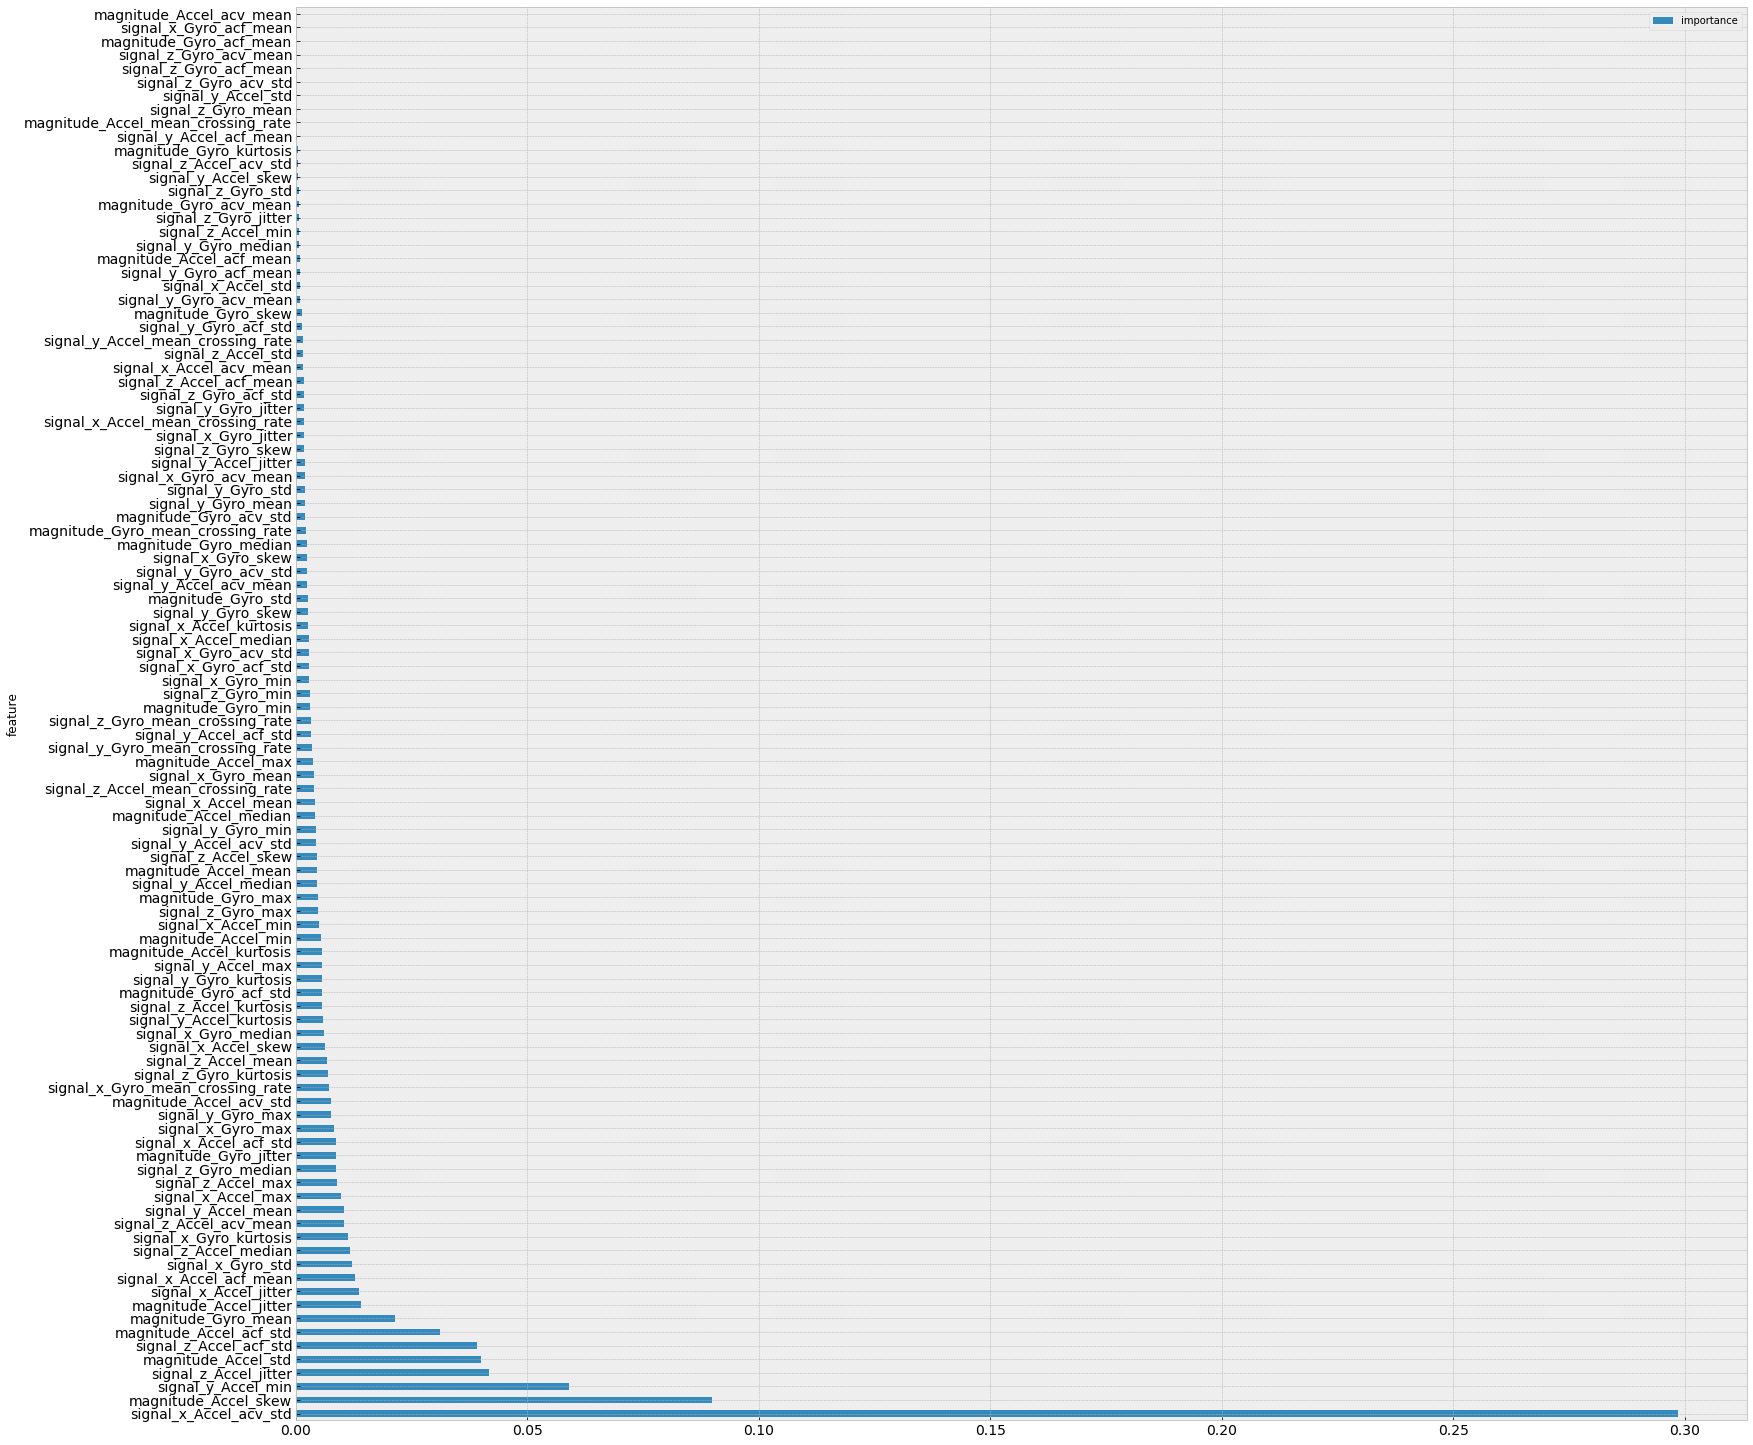

In [62]:
feature_importances = pd.Series(c.feature_importances_, index=FEATURES_COLS).sort_values(ascending=False)
feature_importance_df = pd.DataFrame(feature_importances)
feature_importance_df.reset_index(inplace=True)
feature_importance_df.columns = ['feature', 'importance']
feature_importance_df.set_index('feature').plot(kind='barh', figsize=(26, 26), fontsize=14)

### CHecking the additional test examples we got from Nexar. there are 100 high_rated and 100 zero_rated additional samples. We don't know which is which


In [85]:
!ls nexar
test_samples = glob.glob("nexar/*/*_Accel.csv")
test_samples[:10]
print("there are {} samples".format(len(test_samples)))

f1  f2	high_rated-2018-11-24  zero_rated-2018-11-24
there are 200 samples


In [86]:
def get_test_ids(fname):
    """Calculate `sample_id` and short filename."""
    start_dir, filename = os.path.split(fname)
    base_dir, sample_id = os.path.split(start_dir)
    _, sample_class = os.path.split(base_dir)
    sample_class= sample_class
    sample_class=filename.split("_")[0]
    return (sample_id, sample_class, filename)

In [87]:
get_test_ids(test_samples[0])
test_files = pd.DataFrame([get_test_ids(sample) for sample in test_samples],columns=["class", "sample_id", "accel_file"])

In [88]:
test_files.head()
f2=test_files[test_files["class"]=="f2"]
f1=test_files[test_files["class"]=="f1"]
f1.head()

,class,sample_id,accel_file
100,f1,b8da5016693d587883833c4a0405c0ed,b8da5016693d587883833c4a0405c0ed_Accel.csv
101,f1,b0ac3c4e524d0670b845c8db5f993db6,b0ac3c4e524d0670b845c8db5f993db6_Accel.csv
102,f1,b56a7f7ee5096a8f31de214afd03e12c,b56a7f7ee5096a8f31de214afd03e12c_Accel.csv
103,f1,b34fbd1cdc980499b4b53c4aea91f724,b34fbd1cdc980499b4b53c4aea91f724_Accel.csv
104,f1,b4e7191e747d4a494aa674e81de2df5a,b4e7191e747d4a494aa674e81de2df5a_Accel.csv


In [89]:
def generate_test_features(base_dir, sample_class, sample_id, filename):
    # Reading
    fullname = os.path.join(base_dir, sample_class, filename)
#     print("full name: {}".format(fullname))
    sample = pd.read_csv(fullname)
#     print(sample.shape)
#     print(sample.head()) 
    # Handling timestamps and spacing
    sample["timestamp"] = pd.to_datetime(sample['timestamp'], unit="s")
    
    
    
    sample = sample.resample('1S', on="timestamp").mean()
#     print(sample.shape)
#     print(sample.head())
    
    # Acceleration
    sample["magnitude"] = np.sqrt(np.square(sample).sum(axis=1))
    
    # Statistical aggregates

    # Note the trickery to get right format from pandas
    # without manual renaming
    aggs = (sample
            .apply(["mean", "std", "min", "max","median","skew","kurtosis",acf_mean,acf_std,acv_mean,acv_std,jitter,mean_crossing_rate])
            .unstack()
            .reset_index())
    aggs["feature"] = aggs["level_0"].str.cat(aggs["level_1"], sep="_")

    return aggs.set_index("feature")[0]
    

## get gyro data from nexar for this

In [64]:
features_test1=f1.apply(lambda f: generate_test_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)
features_test2=f2.apply(lambda f: generate_test_features(DATA_DIR, *f[["class", "sample_id", "accel_file"]].tolist()),
                            axis=1)

NameError: name 'f1' is not defined

In [91]:
# def generate_features(base_dir, sample_class, sample_id, filename):

In [63]:
test1_pred =c.predict(features_test1)
test2_pred = c.predict(features_test2)


NameError: name 'features_test1' is not defined

In [ ]:
y1_proba=c.predict_proba(features_test1)
y2_proba=c.predict_proba(features_test2)

In [ ]:
df_yproba1=pd.DataFrame(y1_proba)
df_yproba2=pd.DataFrame(y2_proba)
df_yproba1.head()

In [137]:
print('predict majority class for unknown file f1')
print("mean proba for zero class {}".format(df_yproba1.loc[:,0].mean()))
print("mean proba for one class {}".format(df_yproba1.loc[:,1].mean()))


predict majority class for unknown file f1
mean proba for zero class 0.24520000000000014
mean proba for one class 0.7547999999999999


In [139]:
print('predict majority class for unknown file f2')
print("mean proba for zero class {}".format(df_yproba2.loc[:,0].mean()))
print("mean proba for one class {}".format(df_yproba2.loc[:,1].mean()))

predict majority class for unknown file f2
mean proba for zero class 0.6710499999999999
mean proba for one class 0.32895
